# Artificial Neural Networks and Deep Learning

---

## Homework 1: Minimal Working Example

To make your first submission, follow these steps:
1. Create a folder named `[2024-2025] AN2DL/Homework 1` in your Google Drive.
2. Upload the `training_set.npz` file to this folder.
3. Upload the Jupyter notebook `Homework 1 - Minimal Working Example.ipynb`.
4. Load and process the data.
5. Implement and train your model.
6. Submit the generated `.zip` file to Codabench.


## 🌐 Connect Colab to Google Drive

In [1]:
#from google.colab import drive

#drive.mount('/gdrive')
#%cd /gdrive/My Drive/[2024-2025] AN2DL/Homework 1

## ⚙️ Import Libraries

In [2]:
import numpy as np
import tensorflow as tf

import matplotlib.pyplot as plt
from tensorflow import keras as tfk
from tensorflow.keras import layers as tfkl

import keras_cv.layers

seed = 11037
np.random.seed(seed)
tf.random.set_seed(seed)

import random
random.seed(seed)

2024-11-12 21:13:02.130312: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-11-12 21:13:02.170701: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-11-12 21:13:02.181150: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-11-12 21:13:02.210681: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-11-12 21:13:03.918313: W tensorflow/compiler/tf2

## ⏳ Load the Data

In [3]:
# Read training_set.npz to get the dataframe.
data = np.load('training_set.npz', allow_pickle=True)

# Normal images up to 11958, shrek from 11959 to 13558, rick from 13559 to 13758.
images = data['images'][:11959]
labels = data['labels'][:11959]

In [4]:
# Images are stored as 96x96x3 numpy arrays.
print("Shape of all images:")
print(images[0].shape)

# Count the images.
print()
print("Total number of images: ")
total_num_images = images.shape[0]
print(total_num_images)

# Count the amount of images with a given label.
print()
print("Number of images with a given label:")
for n, elm in enumerate(np.unique(labels, return_counts=True)[-1]):
    print(f"Label {n}: {elm} ({np.round(elm/total_num_images*100, 1)}%)")

Shape of all images:
(96, 96, 3)

Total number of images: 
11959

Number of images with a given label:
Label 0: 852 (7.1%)
Label 1: 2181 (18.2%)
Label 2: 1085 (9.1%)
Label 3: 2026 (16.9%)
Label 4: 849 (7.1%)
Label 5: 993 (8.3%)
Label 6: 2330 (19.5%)
Label 7: 1643 (13.7%)


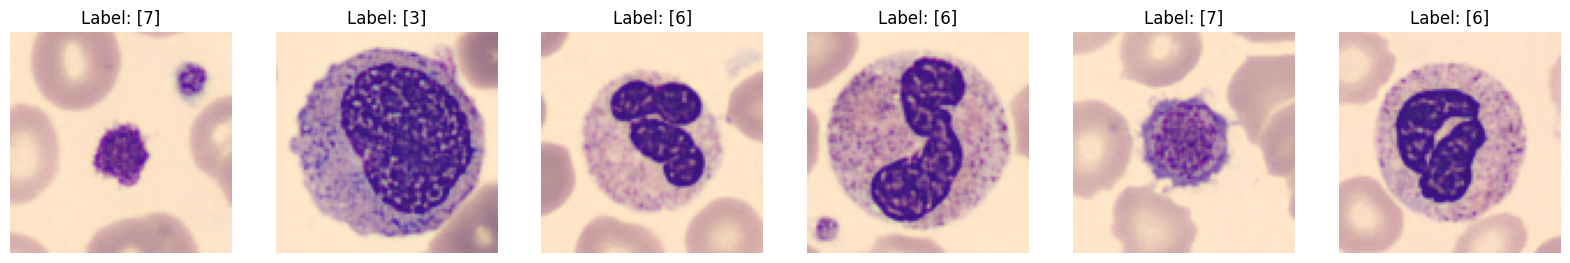

In [5]:
# Display the first few images with matplotlib.
plotted_images = 6
fig, axs = plt.subplots(1, plotted_images, figsize=(20, 20))

for i in range(plotted_images):
    axs[i].imshow(images[i])
    axs[i].set_title(f"Label: {labels[i]}")
    axs[i].axis('off')

plt.show()


## Split in train, validation and test sets

In [39]:
from sklearn.model_selection import train_test_split

# Split the dataset into a combined training and validation set, and a separate
# test set.
X_train_val, X_test, y_train_val, y_test = train_test_split(
    images,
    labels,
    test_size=0.1,
    random_state=seed,
    stratify=labels
)

# Split the training and validation sets.
X_train, X_val, y_train, y_val = train_test_split(
    X_train_val,
    y_train_val,
    test_size=0.2,
    random_state=seed,
    stratify=y_train_val
)

# Print the shapes of the resulting sets.
print('Overall shape:\t\t', images.shape, labels.shape)
print('Training set shape:\t', X_train.shape, y_train.shape)
print('Validation set shape:\t', X_val.shape, y_val.shape)
print('Test set shape:\t\t', X_test.shape, y_test.shape)

Overall shape:		 (11959, 96, 96, 3) (11959, 1)
Training set shape:	 (8610, 96, 96, 3) (8610, 1)
Validation set shape:	 (2153, 96, 96, 3) (2153, 1)
Test set shape:		 (1196, 96, 96, 3) (1196, 1)


## Process data

### Overlay images with another image

In [7]:
def overlay(image, background_name, alpha):
    # Pick two random images from the dataset.
    image_background = tfk.preprocessing.image.load_img(background_name)
    image_background = tfk.preprocessing.image.img_to_array(image_background).astype('uint8')
    image_overlay = image

    # Set the input image to be in the range [0, 1],
    # with type float32.
    image_background = image_background.astype('float32') / 255
    image_overlay = image_overlay.astype('float32') / 255

    # Multiply the background image by the overlay image.
    image_result = alpha*image_background + (1-alpha)*image_overlay

    # Clip the result image to be in the range [0, 1].
    image_result = np.clip(image_result, 0, 1)

    # Set it back to a 0 to 255 uint8 image.
    image_result = (image_result * 255).astype('uint8')

    return image_result

First pixel of the result image:
[254 244 233]


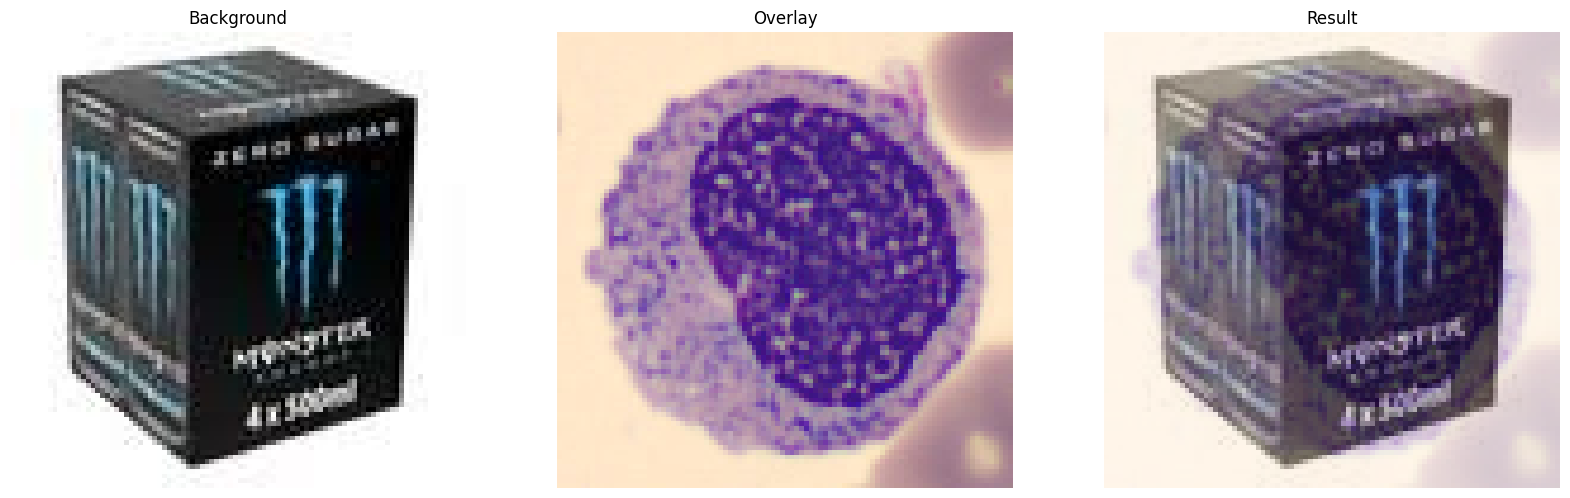

In [8]:
# Pick two random images from the dataset.
background_filename = "overlays/monster.jpeg"
image_background = tfk.preprocessing.image.load_img(background_filename)
image_background = tfk.preprocessing.image.img_to_array(image_background).astype('uint8')
image_overlay = images[1]

# Display the images.
fig, axs = plt.subplots(1, 3, figsize=(20, 20))

axs[0].imshow(image_background)
axs[0].set_title("Background")
axs[0].axis('off')

axs[1].imshow(image_overlay)
axs[1].set_title("Overlay")
axs[1].axis('off')

# Clip the result image to be in the range [0, 1].
image_result = overlay(image_overlay, background_filename, 0.6)

print("First pixel of the result image:")
print(image_result[0, 0])

axs[2].imshow(image_result)
axs[2].set_title("Result")
axs[2].axis('off')

plt.show()


In [ ]:
"""
import os
random.seed(seed)

alpha_range = [0.25, 0.75]

# Overlay images in each set, using different images for different sets.
overlays = [f for f in os.listdir("keras_overlays")]
for i, over in enumerate(overlays):
    overlays[i] = "keras_overlays/" + over

num_overlays = len(overlays)
train_ratio = X_train.shape[0] / images.shape[0]
val_ratio = X_val.shape[0] / images.shape[0]
test_ratio = X_test.shape[0] / images.shape[0]

end_train_idx = int(train_ratio*num_overlays)
end_val_idx = int((train_ratio+val_ratio)*num_overlays)
train_overlays = overlays[:end_train_idx]
val_overlays = overlays[end_train_idx:end_val_idx]
test_overlays = overlays[end_val_idx:]

image_sets = [X_train, X_val, X_test]
overlays_list = [train_overlays, val_overlays, test_overlays]

for i in range(3):
    image_set = image_sets[i]
    set_overlays = overlays_list[i]
    for idx, image in enumerate(image_set):
        img_overlay = random.choice(set_overlays)
        alpha = alpha_range[0] + random.random()*(alpha_range[1]-alpha_range[0])
        image_set[idx] = overlay(image, img_overlay, alpha)
"""

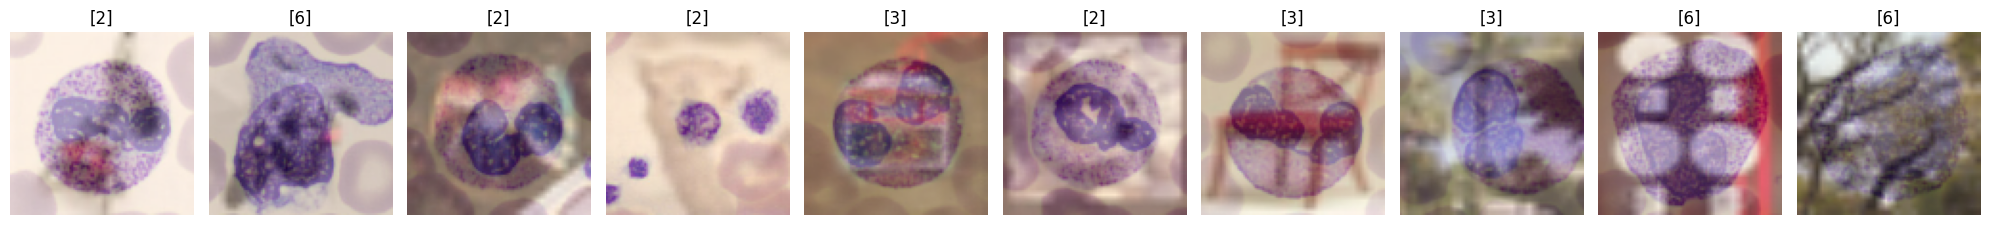

In [10]:
# Display a sample of images from the dataset.
set_to_sample = X_train
labels_to_sample = y_train
num_img = 10
random_indices = random.sample(range(len(set_to_sample)), num_img)

fig, axes = plt.subplots(1, num_img, figsize=(20, 20))

# Iterate through the selected number of images.
for i, idx in enumerate(random_indices):
    ax = axes[i % num_img]
    ax.imshow(np.squeeze(set_to_sample[idx]), vmin=0., vmax=1.)
    ax.set_title(str(data['labels'][labels_to_sample[idx][0]]))
    ax.axis('off')

# Adjust layout and display the images.
plt.tight_layout()
plt.show()

### Normalize data and encode labels

In [40]:
# Normalize data to the range [0, 1].
X_train = (X_train / 255).astype('float32')
X_val = (X_val / 255).astype('float32')

# Print the first few pixel values of the first image, to verify that the
# normalization was successful.
print('First image pixel values:')
print(X_train[0, 0, 0, :])

y_train = tfk.utils.to_categorical(y_train)
y_val = tfk.utils.to_categorical(y_val)

First image pixel values:
[0.84705883 0.7137255  0.6784314 ]


In [41]:
# Create a preprocessing pipeline with augmentations.
batch_size = 128
num_classes = 8
augmenter = keras_cv.layers.Augmenter(
    [
        keras_cv.layers.RandomFlip(),
        keras_cv.layers.RandAugment(value_range=(0, 1)),
        keras_cv.layers.CutMix(),
    ],
)

def preprocess_data(images, labels, augment=False):
    # Convert labels to categorical format using one-hot encoding.
    inputs = {"images": images, "labels": labels}
    outputs = inputs
    if augment:
        outputs = augmenter(outputs)
    return outputs['images'], outputs['labels']

# Augment the training and validation datasets.
train_dataset = tf.data.Dataset.from_tensor_slices((X_train, y_train))

train_dataset = train_dataset.batch(batch_size).map(
    lambda x, y: preprocess_data(x, y, augment=True),
        num_parallel_calls=tf.data.AUTOTUNE).prefetch(
            tf.data.AUTOTUNE)

val_dataset = tf.data.Dataset.from_tensor_slices((X_val, y_val))

val_dataset = val_dataset.batch(batch_size).map(
    lambda x, y: preprocess_data(x, y, augment=True),
        num_parallel_calls=tf.data.AUTOTUNE).prefetch(
            tf.data.AUTOTUNE)

## 🧮 Define Network Parameters

In [43]:
# Input shape for the model.
input_shape = train_dataset.element_spec[0].shape[1:]

# Output shape for the model.
output_shape = train_dataset.element_spec[1].shape[1]

print("Input Shape:", input_shape)
print("Output Shape:", output_shape)

Input Shape: (96, 96, 3)
Output Shape: 8


In [44]:
# Number of training epochs.
epochs = 1000

# Batch size for training.
batch_size = 128

# Learning rate: step size for updating the model's weights.
learning_rate = 0.001

# Print the defined parameters.
print("Epochs:", epochs)
print("Batch Size:", batch_size)
print("Learning Rate:", learning_rate)

Epochs: 1000
Batch Size: 128
Learning Rate: 0.001


## 💪 Image Augmentation

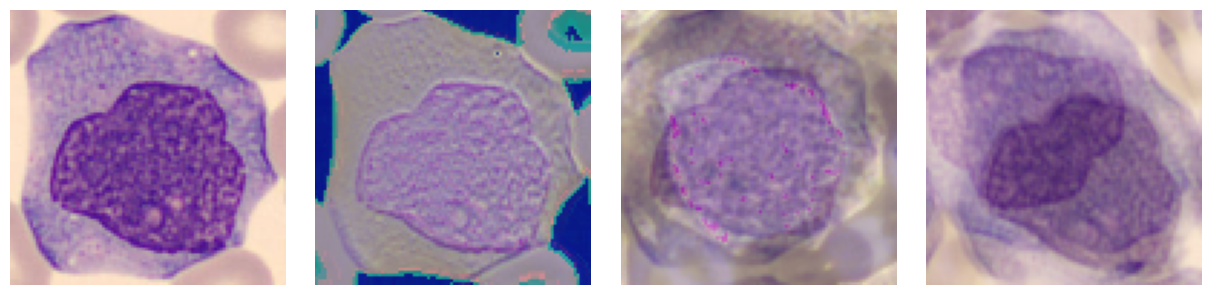

In [57]:
import matplotlib.gridspec as gridspec
img = X_train[0]

# Define a sequential model for image augmentation.
augmentation = tf.keras.Sequential([
    keras_cv.layers.RandAugment(
        value_range=(0,1),
        magnitude=0.1,
        magnitude_stddev=0.01
    ),
    keras_cv.layers.AugMix(
        value_range=(0,1)
    )
], name='preprocessing')

# Set up the figure and grid layout for displaying images.
fig = plt.figure(constrained_layout=True, figsize=(12, 3))
gs = gridspec.GridSpec(1, 4, figure=fig, width_ratios=[1, 1, 1, 1], wspace=0.1)

# Display the original image.
ax1 = fig.add_subplot(gs[0])
ax1.imshow(np.squeeze(img))
ax1.axis('off')

# Apply augmentation and display the first augmented image.
augmented_img = np.clip(augmentation(img), 0., 1.)
ax2 = fig.add_subplot(gs[1])
ax2.imshow(np.squeeze(augmented_img))
ax2.axis('off')

# Apply augmentation again and display the second augmented image.
augmented_img = np.clip(augmentation(img), 0., 1.)
ax3 = fig.add_subplot(gs[2])
ax3.imshow(np.squeeze(augmented_img))
ax3.axis('off')

# Apply augmentation again and display the third augmented image.
augmented_img = np.clip(augmentation(img), 0., 1.)
ax4 = fig.add_subplot(gs[3])
ax4.imshow(np.squeeze(augmented_img))
ax4.axis('off')

# Show the figure with all images.
plt.show()

## 🛠️ Build the Model

In [45]:
def build_model(
    input_shape=input_shape,
    output_shape=output_shape,
    learning_rate=learning_rate,
    augmentation=None,
    seed=seed
):
    # Set the random seed for reproducibility.
    tf.random.set_seed(seed)

    # Define the input layer
    input_layer = tfkl.Input(shape=input_shape, name='Input')

    # Apply optional data augmentation, then first convolutional layer.
    if augmentation == None:
        x = tfkl.Conv2D(filters=16, kernel_size=3, padding='same', name='conv0')(input_layer)
    else:
        x = augmentation(input_layer)
        x = tfkl.Conv2D(filters=16, kernel_size=3, padding='same', name='conv0')(x)

    # Apply activation and pooling after the first convolution.
    x = tfkl.ReLU(name='relu0')(x)
    x = tfkl.MaxPooling2D(name='mp0')(x)

    # Apply second convolutional layer, activation, and pooling.
    x = tfkl.Conv2D(filters=32, kernel_size=3, padding='same', name='conv1')(x)
    x = tfkl.ReLU(name='relu1')(x)
    x = tfkl.MaxPooling2D(name='mp1')(x)

    # Apply third convolutional layer, activation, and pooling.
    x = tfkl.Conv2D(filters=64, kernel_size=3, padding='same', name='conv2')(x)
    x = tfkl.ReLU(name='relu2')(x)
    x = tfkl.MaxPooling2D(name='mp2')(x)

    # Apply fourth convolutional layer, activation, and pooling.
    x = tfkl.Conv2D(filters=128, kernel_size=3, padding='same', name='conv3')(x)
    x = tfkl.ReLU(name='relu3')(x)
    x = tfkl.MaxPooling2D(name='mp3')(x)

    # Apply a fifth convolutional layer with activation.
    x = tfkl.Conv2D(filters=256, kernel_size=3, padding='same', name='conv4')(x)
    x = tfkl.ReLU(name='relu4')(x)

    # Apply global average pooling.
    x = tfkl.GlobalAveragePooling2D(name='gap')(x)

    # Add a dense layer with activation.
    x = tfkl.Dense(units=128, name='dense1')(x)
    x = tfkl.ReLU(name='relu5')(x)
    # Add a dropout layer to prevent overfitting.
    x = tfkl.Dropout(rate=0.6, name='dropout')(x)

    # Define the output layer with softmax activation for classification.
    x = tfkl.Dense(units=output_shape, name='dense2')(x)
    output_layer = tfkl.Activation('softmax', name='softmax')(x)

    # Create the model.
    model = tfk.Model(inputs=input_layer, outputs=output_layer, name='CNN')

    # Compile the model with categorical crossentropy loss and Adam optimizer.
    loss = tfk.losses.CategoricalCrossentropy()
    optimizer = tfk.optimizers.Adam(learning_rate)
    metrics = ['accuracy']
    model.compile(loss=loss, optimizer=optimizer, metrics=metrics)

    # Return the compiled model.
    return model

In [46]:
augmentation = tf.keras.Sequential([
    tfkl.RandomFlip("horizontal_and_vertical"),
    tfkl.RandomTranslation(0.2,0.2),
    tfkl.RandomRotation(0.2),
    tfkl.RandomZoom(0.2),
    tfkl.RandomBrightness(0.5, value_range=(0,1)),
    tfkl.RandomContrast(0.75),
    #keras_cv.layers.RandomSaturation((0.25,0.75)),
    #keras_cv.layers.RandomHue((0.25,0.75), [0,1]),
], name='preprocessing')

# Build the model with specified input and output shapes.
model = build_model(augmentation=augmentation)

# Display a summary of the model architecture.
model.summary(expand_nested=True, show_trainable=True)

# Plot the model architecture.
try:
    tfk.utils.plot_model(model, expand_nested=True, show_trainable=True, show_shapes=True, dpi=70)
except:
    print("Model too complex to plot.")

Model: "CNN"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━┓
┃ Layer (type)                ┃ Output Shape          ┃    Param # ┃ Trai… ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━┩
│ Input (InputLayer)          │ (None, 96, 96, 3)     │          0 │   -   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ preprocessing (Sequential)  │ (None, 96, 96, 3)     │          0 │   -   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│    └ random_flip_8          │ (None, 96, 96, 3)     │          0 │   -   │
│ (RandomFlip)                │                       │            │       │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│    └ random_translation_16  │ (None, 96, 96, 3)     │          0 │   -   │
│ (RandomTranslation)         │                       │            │       │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│    └ random_rotation        │ (None, 96, 96, 3)     │          0 │   -   │
│ (RandomRotation)            │                       │            │       │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│    └ random_zoom            │ (None, 96, 96, 3)     │          0 │   -   │
│ (RandomZoom)                │                       │            │       │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│    └ random_brightness_8    │ (None, 96, 96, 3)     │          0 │   -   │
│ (RandomBrightness)          │                       │            │       │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│    └ random_contrast_8      │ (None, 96, 96, 3)     │          0 │   -   │
│ (RandomContrast)            │                       │            │       │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ conv0 (Conv2D)              │ (None, 96, 96, 16)    │        448 │   Y   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ relu0 (ReLU)                │ (None, 96, 96, 16)    │          0 │   -   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ mp0 (MaxPooling2D)          │ (None, 48, 48, 16)    │          0 │   -   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ conv1 (Conv2D)              │ (None, 48, 48, 32)    │      4,640 │   Y   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ relu1 (ReLU)                │ (None, 48, 48, 32)    │          0 │   -   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ mp1 (MaxPooling2D)          │ (None, 24, 24, 32)    │          0 │   -   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ conv2 (Conv2D)              │ (None, 24, 24, 64)    │     18,496 │   Y   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ relu2 (ReLU)                │ (None, 24, 24, 64)    │          0 │   -   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ mp2 (MaxPooling2D)          │ (None, 12, 12, 64)    │          0 │   -   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ conv3 (Conv2D)              │ (None, 12, 12, 128)   │     73,856 │   Y   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ relu3 (ReLU)                │ (None, 12, 12, 128)   │          0 │   -   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ mp3 (MaxPooling2D)          │ (None, 6, 6, 128)     │          0 │   -   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ conv4 (Conv2D)              │ (None, 6, 6, 256)     │    295,168 │   Y   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ relu4 (ReLU)                │ (None, 6, 6, 256)     │          0 │   - 

 Total params: 426,536 (1.63 MB)

 Trainable params: 426,536 (1.63 MB)

 Non-trainable params: 0 (0.00 B)

## 🛠️ Train and Save the Model

In [47]:
# Define the patience value for early stopping.
patience = 40

# Create an EarlyStopping callback.
early_stopping = tfk.callbacks.EarlyStopping(
    monitor='val_accuracy',
    mode='max',
    patience=patience,
    restore_best_weights=True
)

reduce_lr = tfk.callbacks.ReduceLROnPlateau(
    monitor="val_loss",
    factor=0.2,
    patience=patience//2
)

# Store the callback in a list.
callbacks = [early_stopping, reduce_lr]

In [48]:
# Train the model with early stopping callback.
history = model.fit(
    train_dataset,
    batch_size=batch_size,
    epochs=epochs,
    validation_data=val_dataset,
    callbacks=callbacks
).history

# Calculate and print the final validation accuracy.
final_val_accuracy = round(max(history['val_accuracy'])* 100, 2)
print(f'Final validation accuracy: {final_val_accuracy}%')

# Save the trained model to a file with the accuracy included in the filename.
model_filename = 'weights.keras'
model.save(model_filename)

# Delete the model to free up resources.
del model

Epoch 1/1000


2024-11-12 21:28:27.871517: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:531] Loaded cuDNN version 8907
W0000 00:00:1731443308.224811  583715 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1731443308.320714  583715 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1731443308.322893  583715 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1731443308.325586  583715 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1731443308.328104  583715 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1731443308.331010  583715 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1731443308.352700  583715 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1731443308.355991  583715 gpu_t

67/68 ━━━━━━━━━━━━━━━━━━━━ 0s 403ms/step - accuracy: 0.1651 - loss: 2.0481

W0000 00:00:1731443336.771284  583714 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1731443336.772847  583714 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1731443336.774225  583714 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1731443336.775652  583714 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1731443336.777025  583714 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1731443336.778325  583714 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1731443336.779641  583714 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1731443336.780955  583714 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1731443336.782376  583714 gp

68/68 ━━━━━━━━━━━━━━━━━━━━ 0s 404ms/step - accuracy: 0.1653 - loss: 2.0478

W0000 00:00:1731443337.176320  583713 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1731443337.177883  583713 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1731443337.179530  583713 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1731443337.180843  583713 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1731443337.200462  583713 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1731443337.201656  583713 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1731443337.203027  583713 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1731443337.204275  583713 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1731443337.206393  583713 gp

68/68 ━━━━━━━━━━━━━━━━━━━━ 58s 582ms/step - accuracy: 0.1654 - loss: 2.0476 - val_accuracy: 0.1867 - val_loss: 2.0112 - learning_rate: 0.0010
Epoch 2/1000


W0000 00:00:1731443348.959454  583717 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1731443348.962125  583717 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1731443348.963643  583717 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1731443348.965054  583717 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1731443348.966462  583717 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1731443348.967987  583717 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1731443348.969844  583717 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1731443348.971362  583717 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1731443348.973397  583717 gp

68/68 ━━━━━━━━━━━━━━━━━━━━ 39s 510ms/step - accuracy: 0.1835 - loss: 2.0185 - val_accuracy: 0.2243 - val_loss: 1.9966 - learning_rate: 0.0010
Epoch 3/1000
68/68 ━━━━━━━━━━━━━━━━━━━━ 40s 517ms/step - accuracy: 0.1857 - loss: 2.0191 - val_accuracy: 0.2146 - val_loss: 1.9971 - learning_rate: 0.0010
Epoch 4/1000
68/68 ━━━━━━━━━━━━━━━━━━━━ 37s 472ms/step - accuracy: 0.1942 - loss: 2.0125 - val_accuracy: 0.2401 - val_loss: 1.9827 - learning_rate: 0.0010
Epoch 5/1000
68/68 ━━━━━━━━━━━━━━━━━━━━ 36s 457ms/step - accuracy: 0.2083 - loss: 2.0033 - val_accuracy: 0.2188 - val_loss: 1.9949 - learning_rate: 0.0010
Epoch 6/1000
68/68 ━━━━━━━━━━━━━━━━━━━━ 36s 463ms/step - accuracy: 0.2165 - loss: 2.0005 - val_accuracy: 0.2271 - val_loss: 1.9817 - learning_rate: 0.0010
Epoch 7/1000
68/68 ━━━━━━━━━━━━━━━━━━━━ 35s 451ms/step - accuracy: 0.2144 - loss: 2.0042 - val_accuracy: 0.2666 - val_loss: 1.9499 - learning_rate: 0.0010
Epoch 8/1000
68/68 ━━━━━━━━━━━━━━━━━━━━ 35s 452ms/step - accuracy: 0.2301 - loss: 1

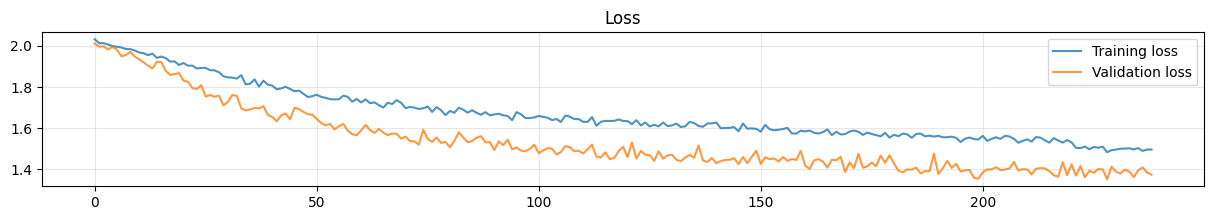

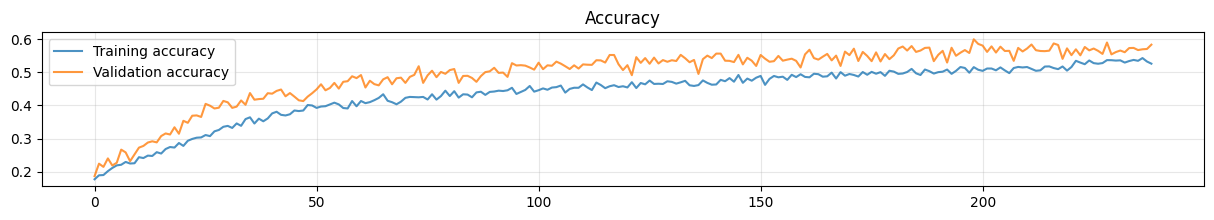

In [49]:
# Plot training and validation loss.
plt.figure(figsize=(15, 2))
plt.plot(history['loss'], label='Training loss', alpha=.8)
plt.plot(history['val_loss'], label='Validation loss', alpha=.8)
plt.title('Loss')
plt.legend()
plt.grid(alpha=.3)

# Plot training and validation accuracy.
plt.figure(figsize=(15, 2))
plt.plot(history['accuracy'], label='Training accuracy', alpha=.8)
plt.plot(history['val_accuracy'], label='Validation accuracy', alpha=.8)
plt.title('Accuracy')
plt.legend()
plt.grid(alpha=.3)
plt.show()

## 📊 Prepare the Submission

To prepare your submission, create a `.zip` file that includes all the necessary code to run your model. It **must** include a `model.py` file with the following class:

```python
# file: model.py
class Model:
    def __init__(self):
        """Initialize the internal state of the model."""

    def predict(self, X):
        """Return a numpy array with the labels corresponding to the input X."""
```

The next cell shows an example implementation of the `model.py` file, which includes loading model weights from the `weights.keras` file and conducting predictions on provided input data. The `.zip` file is created and downloaded in the last notebook cell.

❗ Feel free to modify the method implementations to better fit your specific requirements, but please ensure that the class name and method interfaces remain unchanged.

In [50]:
%%writefile model.py
import numpy as np

import tensorflow as tf
from tensorflow import keras as tfk
from tensorflow.keras import layers as tfkl


class Model:
    def __init__(self):
        # Load the CNN.
        self.neural_network = tfk.models.load_model('weights.keras')

    def predict(self, X):
        # Map X to [0,1].
        X_normalized = (X / 255).astype('float32')

        # Predict.
        preds = self.neural_network.predict(X_normalized)
        if len(preds.shape) == 2:
            preds = np.argmax(preds, axis=1)
        return preds

Overwriting model.py


In [51]:
from datetime import datetime
filename = f'submission_{datetime.now().strftime("%y%m%d_%H%M%S")}.zip'

# Add files to the zip command if needed.
!zip {filename} model.py weights.keras

#from google.colab import files
#files.download(filename)

  adding: model.py (deflated 48%)
  adding: weights.keras (deflated 8%)


## 🕹️ Test the Model

In [52]:
import model
model_object = model.Model()

W0000 00:00:1731452322.711173  583717 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1731452322.712908  583717 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1731452322.714187  583717 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1731452322.715561  583717 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1731452322.716922  583717 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1731452322.718343  583717 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1731452322.719766  583717 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1731452322.721417  583717 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1731452322.723244  583717 gp

24/38 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step

W0000 00:00:1731452322.912497  583717 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1731452322.914103  583717 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced


38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step


W0000 00:00:1731452323.460134  583717 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1731452323.461423  583717 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1731452323.462450  583717 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1731452323.463446  583717 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1731452323.464410  583717 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1731452323.465418  583717 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1731452323.466433  583717 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1731452323.467461  583717 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1731452323.468510  583717 gp

Accuracy score over the test set: 0.8545
Precision score over the test set: 0.881
Recall score over the test set: 0.8545
F1 score over the test set: 0.8534


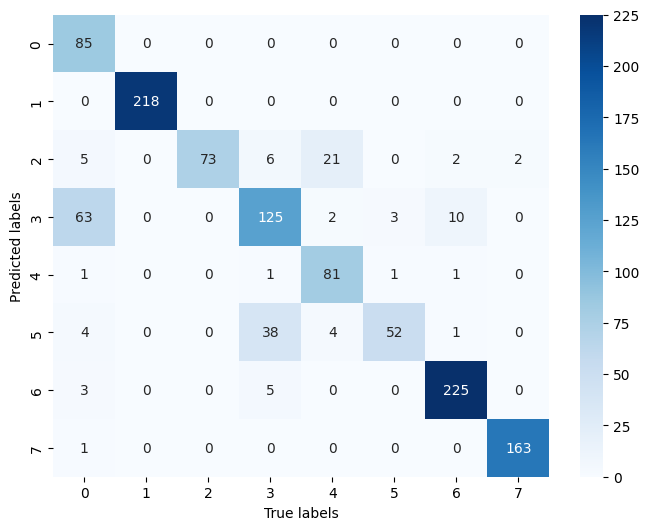

In [53]:
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, confusion_matrix
import seaborn as sns

# Predict class probabilities and get predicted classes.
test_predictions = model_object.predict(X_test)

# Extract ground truth classes.
test_gt = y_test

# Calculate and display test set accuracy.
test_accuracy = accuracy_score(test_gt, test_predictions)
print(f'Accuracy score over the test set: {round(test_accuracy, 4)}')

# Calculate and display test set precision.
test_precision = precision_score(test_gt, test_predictions, average='weighted')
print(f'Precision score over the test set: {round(test_precision, 4)}')

# Calculate and display test set recall.
test_recall = recall_score(test_gt, test_predictions, average='weighted')
print(f'Recall score over the test set: {round(test_recall, 4)}')

# Calculate and display test set F1 score.
test_f1 = f1_score(test_gt, test_predictions, average='weighted')
print(f'F1 score over the test set: {round(test_f1, 4)}')

# Compute the confusion matrix.
cm = confusion_matrix(test_gt, test_predictions)

# Create labels combining confusion matrix values.
labels = np.array([f"{num}" for num in cm.flatten()]).reshape(cm.shape)

# Plot the confusion matrix with class labels.
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=labels, fmt='', xticklabels=range(8), yticklabels=range(8), cmap='Blues')
plt.xlabel('True labels')
plt.ylabel('Predicted labels')
plt.show()